## Spectral Clustering and Semi-Supervised Learning

#### This notebook contains different values and imports that can be used in this practical session.
#### Please keep the same variable names when provided in your report to make the work of teaching assistants easier. 
#### You can still change the values given or the sizes of the datasets treated if you believe it is usefull to illustrate your point.

#### You can directly edit the markdown boxes to add your comments and answers to the questions

In [1]:
# Question 1 (imports and advised values):
##from sklearn import datasets
from sklearn.datasets import make_moons
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

n_samples = 200 # You can change these values
noise_level_list = [.01,.05,.1,.2] # You can change these values

### Question 1 : Complete the code in the box below

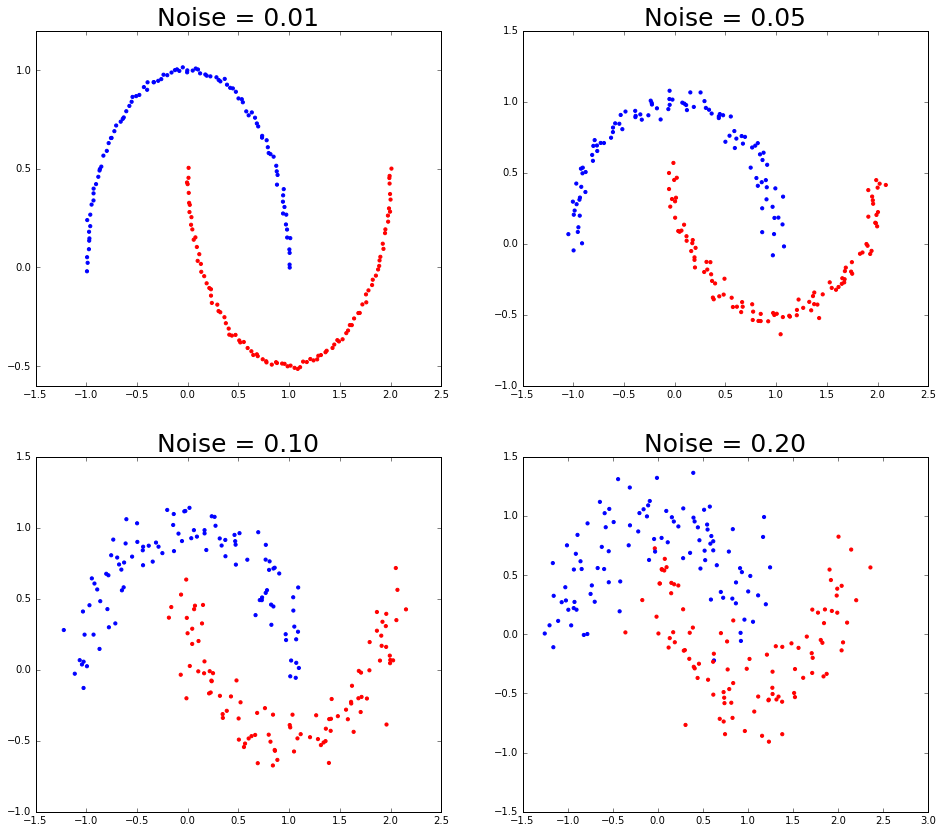

In [2]:
plt.rcParams['figure.figsize'] = (16.0, 14.0)

cpt = 0
colors = np.array([x for x in 'brgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)
for noise_level in noise_level_list:
    cpt = cpt + 1
    noisy_moons = make_moons(n_samples=n_samples, noise=noise_level)
    X, Y = noisy_moons
    plt.subplot(2, 2, cpt)
    plt.scatter(X[:, 0], X[:, 1], color=colors[Y].tolist(), s=10)
    plt.title('Noise = %.2f' % noise_level, fontsize = 25)

### Question 2 : Complete the code in the box below

In [3]:
noise_level_list = [.05,.1,.2]
n_neighbors_list = [1, 5, 10]

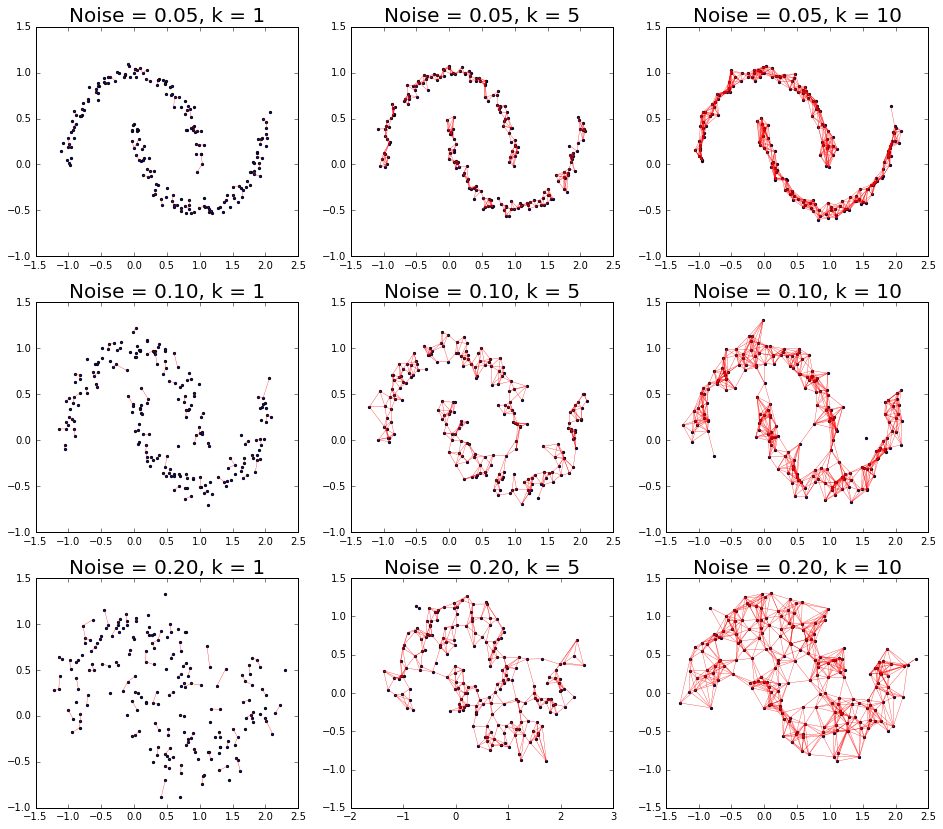

In [4]:
# Question 2 :
from sklearn.neighbors import kneighbors_graph

graphsKNN = list()

for noise_level in noise_level_list:
    for k in n_neighbors_list:
        moon = make_moons(n_samples, shuffle = False, noise=noise_level)
        graph = kneighbors_graph(moon[0], k, mode='distance')
        graphsKNN.append({'moon': moon[0], 'graph': graph, 
                          'noise': noise_level, 'k': k})
        
f, ax = plt.subplots(len(n_neighbors_list), len(noise_level_list))
f.subplots_adjust(wspace = 0.2, hspace=0.2)

for key, val in enumerate(graphsKNN): 
    i, j = divmod(key, 3)
    ax[i, j].scatter(val['moon'][:, 0], val['moon'][:, 1], marker='.')
    xidx, yidx = val['graph'].nonzero()
    for key1, key2 in zip(xidx, yidx):
        if key1 < key2:
                ax[i, j].plot([val['moon'][key1, 0], val['moon'][key2, 0]], [val['moon'][key1, 1], val['moon'][key2, 1]], linewidth=0.3, c='r')
        ax[i, j].set_title('Noise = %.2f, k = %d' % (val['noise'], val['k']), fontsize = 20)

### Question 3 : Optimization problem 

We are going to consider here the degree matrix $D$ combined with the weighted adjacency matrix $W$, both associated to the graph $G$.

Then, we define to Laplacian $L$ for this graph computed as $L$ = $D$ - $W$. 

Now we are going to consider two disjoint subsets of the nodes set of the graph, let's say $A$ and $\bar{A}$ to perform a normalized cut.

That could lead to the optimisation problem as follow:

$$
 \left\{
 \begin{array}{lll}
 \min_A & f^\top L f \
 \\
 \mathrm{s.t.} & f_i = 
 \begin{cases}
    \sqrt{\frac{\text{Vol}(\bar{A})}{\text{Vol}(A)}},& \text{if } v_i\in A\\
    \sqrt{\frac{\text{Vol}(A)}{\text{Vol}(\bar{A})}},& \text{if } v_i\in \bar{A}
\end{cases},&f^\top L f = \text{Vol}(V)\text{Ncut}(A, \bar{A})
 \end{array}
 \right .
$$


We can then relax the problem by allowing f to take arbitrary real values:

$\min_{f\in \mathbb{R}^n} f^\top L f \text{ s.t. } Df \bot \mathbb{1}, f^\top D f = \text{Vol}(V)$

### Question 4 : Complete the code in the box below



C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "
C:\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


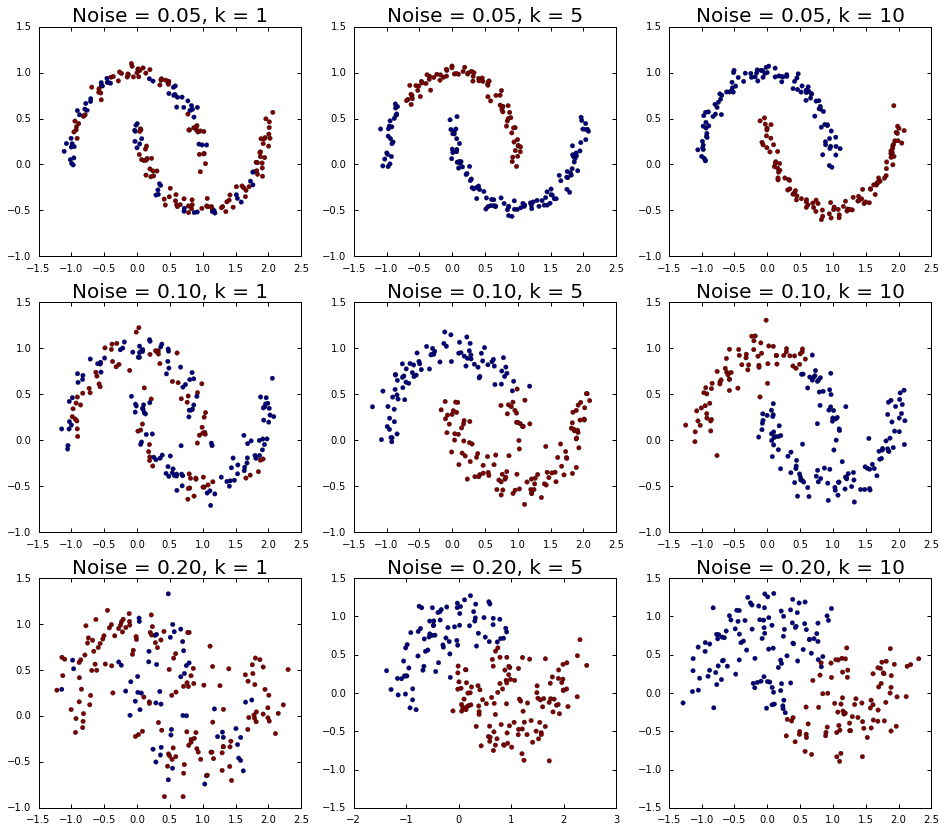

In [5]:
from sklearn.cluster import SpectralClustering

matplotlib.style.use('seaborn-notebook')

plt.rcParams['figure.figsize'] = (16.0, 14.0)

f, ax = plt.subplots(len(n_neighbors_list), len(noise_level_list))
f.subplots_adjust(wspace = 0.2, hspace=0.2)

labels = {}

for key, val in enumerate(graphsKNN): 
    i, j = divmod(key, 3)  
    k = val['k']
    noise = val['noise']
    spectral = SpectralClustering(n_clusters=2, eigen_solver='arpack', affinity="precomputed")
    labels = spectral.fit_predict(val['graph'].todense())
    ax[i, j].scatter(val['moon'][:, 0], val['moon'][:, 1], c = labels)
    ax[i, j].set_title('Noise = %.2f, k = %d' % (noise, k), fontsize = 20)

As the number of k neighbours grows, the clustering seems to perform better. 

### Question 5 : Complete the code in the box below

In [6]:
from numpy import linalg as LA

def matrixRepresentation(labels):
    matrixRep = np.zeros((labels.shape[0],labels.shape[0]))
    
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[i] == labels[j]:
                matrixRep[i][j] = 1
    return matrixRep


def similarity(A, B):
    return np.sum(np.multiply(A,B))/(LA.norm(A)*LA.norm(B))


def compute_stability(clusterAlgorithm, X, B, C, k):
    stability = 0
    originalLabels = clusterAlgorithm(X, C, k)
    originalRepresentationMat = matrixRepresentation(originalLabels)
    
    sampleSize = 0.8*X.shape[0]
    for i in range(B):
        sampleIdx = np.random.choice(X.shape[0], sampleSize, replace=False)
        sample = X[sampleIdx,:]
        sampleLabels = clusterAlgorithm(sample, C, k)
        sampleRepresentationMat = matrixRepresentation(sampleLabels)
        partialOrigRepMat = originalRepresentationMat[sampleIdx, :]
        partialOrigRepMat = partialOrigRepMat[:, sampleIdx]
        
        stability += similarity(sampleRepresentationMat, partialOrigRepMat)
         
    return stability/B

### Question 6 : Complete the code in the box below

In [7]:
noisyX = make_moons(n_samples=n_samples, noise=0.2)[0]
unNoisyX = make_moons(n_samples=n_samples, noise=0.05)[0]

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "
C:\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is no

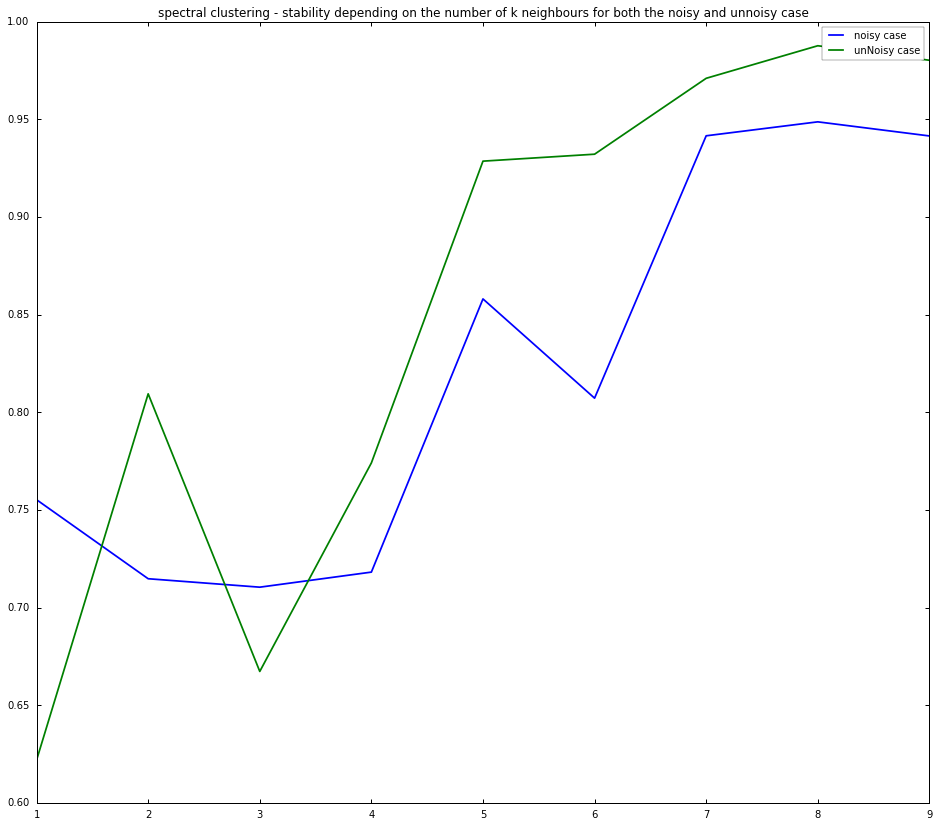

In [8]:
noisyXStabilityArray = []
unNoisyXStabilityArray = []
B = 30 # number of sampled data sets
C = 2 # number of clusters
kArray = np.arange(9) + 1

def clusteralgorithm(X, C, k): 
    graph = kneighbors_graph(X, k, mode='distance')
    spectral = SpectralClustering(n_clusters=C, eigen_solver='arpack', affinity="precomputed")
    labels = spectral.fit_predict(graph.todense()) 
    return labels


for k in kArray:
    stabilityNoisy = compute_stability(clusteralgorithm, noisyX, B , C, k)
    stabilityUnNoisy = compute_stability(clusteralgorithm, unNoisyX, B , C, k)

    noisyXStabilityArray.append(stabilityNoisy)
    unNoisyXStabilityArray.append(stabilityUnNoisy)


plt.plot(kArray, noisyXStabilityArray, label = "noisy case")
plt.plot(kArray, unNoisyXStabilityArray, label = "unNoisy case")
plt.title("spectral clustering - stability depending on the number of k neighbours for both the noisy and unnoisy case")
plt.legend()

Given that the stability of the curves seems to vary greatly depending on k and that the curves seem to eventually reaches a maximum, stability indeed can be used to select thee appropriate k.

### Question 7 : Complete the code in the box below

C:\Anaconda3\lib\site-packages\sklearn\cluster\hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 57 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\sklearn\cluster\hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 47 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)
C:\Anaconda3\lib\site-packages\sklearn\cluster\hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 44 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)
C:\Anaconda3\lib\site-pac

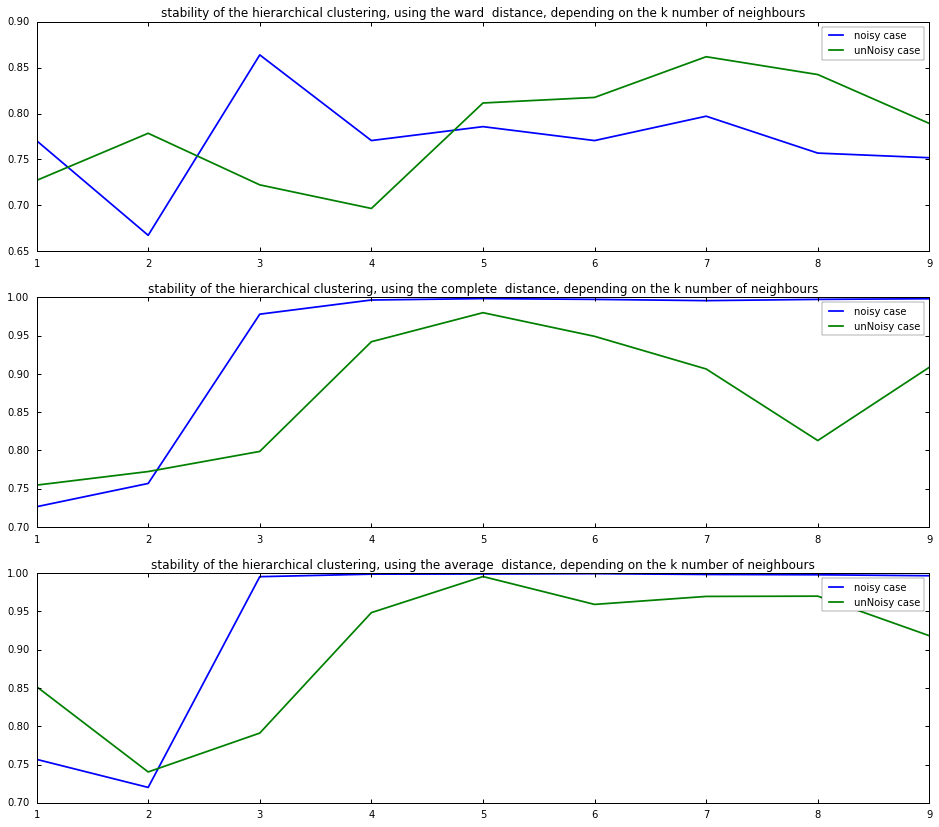

In [ ]:
from sklearn.cluster import AgglomerativeClustering
noisyXStabilityArray = []
unNoisyXStabilityArray = []
B = 30 # number of sampled data sets
C = 2 # number of clusters
kArray = np.arange(9) + 1 #ne pas commencer à 0
cpt = 0
distances = ['ward', 'complete' , 'average']

for distance in distances:
    for k in kArray:

        def clusteralgorithm(X, C, k=k): 
            connectivity = kneighbors_graph(X, n_neighbors=k, include_self=False)
            ward = AgglomerativeClustering(n_clusters=C, connectivity=connectivity, linkage=distance).fit(X)
            labels = ward.labels_
            return labels
  
        stabilityNoisy = compute_stability(clusteralgorithm, noisyX, B , C, k)
        stabilityUnNoisy = compute_stability(clusteralgorithm, unNoisyX, B , C, k)
        noisyXStabilityArray.append(stabilityNoisy)
        unNoisyXStabilityArray.append(stabilityUnNoisy)
        
    cpt += 1
    plt.subplot(3, 1, cpt)
    plt.plot(kArray, noisyXStabilityArray, label = "noisy case")
    plt.plot(kArray, unNoisyXStabilityArray, label = "unNoisy case")
    plt.title("stability of the hierarchical clustering, using the " + distance + "  distance, depending on the k number of neighbours")
    plt.legend()
    noisyXStabilityArray = []
    unNoisyXStabilityArray = []

##### Remark

Based on this example the distance that seems to lead to greater stability is the average distance. Indeed it reaches the highest stability value (30), and reaches it much more often than with the complete distance. The ward distance leads to poorer stability from the hierarchical clustering algorithm. 

### Experiment on MNIST

3


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "
C:\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


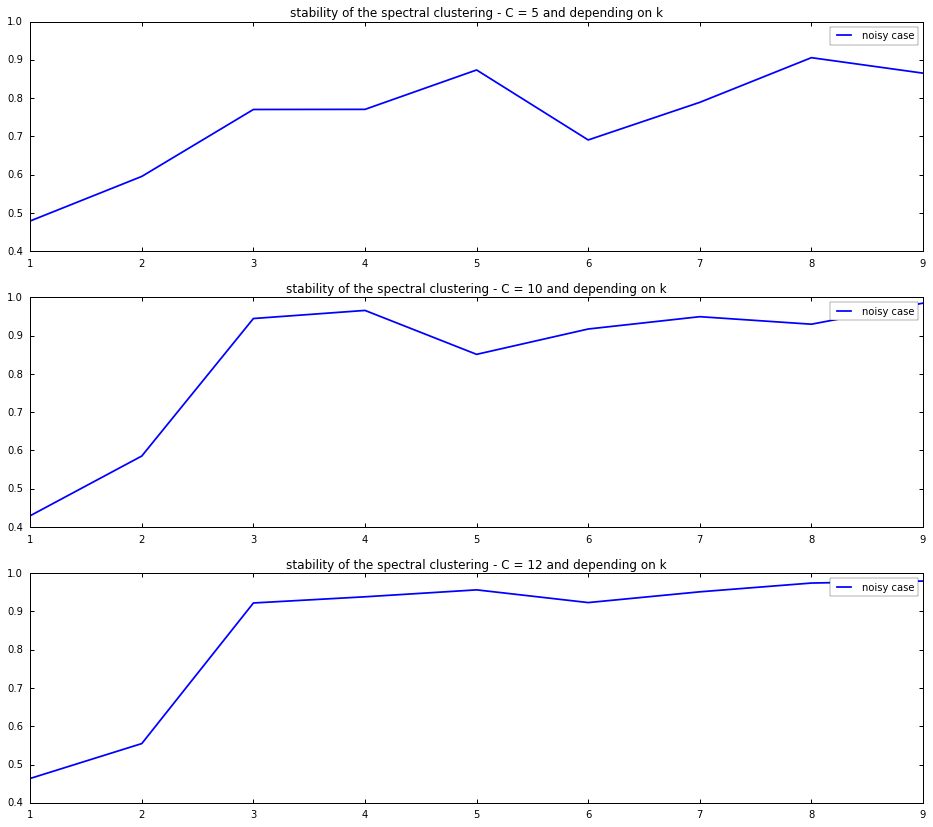

In [ ]:
# Add your code here
from sklearn.datasets import load_digits
from sklearn.cluster import AgglomerativeClustering

digits = load_digits() # quasi sur data c'est X
Xmnist = digits.data


stabilityArray = []
B = 5 # number of sampled data sets
kArray = np.arange(9) + 1 #ne pas commencer à 0
cpt = 0
nbClusters = [5, 10, 12]

print(len(nbClusters))
def clusteralgorithm(X, C, k): 
        graph = kneighbors_graph(X, k, mode='distance')
        spectral = SpectralClustering(n_clusters=C, eigen_solver='arpack', affinity="precomputed")
        labels = spectral.fit_predict(graph.todense()) 
        return labels


for nbCluster in nbClusters:
    for k in kArray:
        stability = compute_stability(clusteralgorithm, Xmnist, B , nbCluster, k)
        stabilityArray.append(stability)
        
    cpt += 1
    plt.subplot(len(nbClusters), 1, cpt)
    plt.plot(kArray, stabilityArray, label = "noisy case")
    plt.title("stability of the spectral clustering - C = " + str(nbCluster) + " and depending on k")
    plt.legend()
    stabilityArray = []

## Semi-Supervised Learning

Choice of the dataset used : **Precise** which dataset you chose and why it is relevant for the semi-supervised learning Task

Advised datasets :

*Breast Cancer Wisconsin (Diagnostic) Database*

*MNIST binary even vs odd (multiple clusters inside each class)*

Feel free to use other datasets if they are relevant

In [ ]:
from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split


### For all the next questions, use Cancer and Mnist classes to handle your data if you choose to use these one,
### You can also add more datasets but we advise you to handle them with this class for better readability
class semi_sup_dat:
    def __init__(self,data,p_unlabelled,name):
        # DON T CHANGE THE RANDOM STATES
        self.name = name
        if self.name == 'Mnist':
            # do an even vs odd binary classification :
            even = [0,2,4,6,8]# transform into binary classification
            Y = [int(y in even) for y in data.target]
        else:
            Y = data.target # deja binary classification
        X_lab, X_unlab, y_lab, y_unlab = train_test_split(data.data, Y, test_size=p_unlabelled, random_state=32)
        self.X_lab = X_lab                              # X         #Y           # faire varier nombre de unlabelled
        self.X_unlab = X_unlab
        self.y_lab = y_lab
        self.y_unlab = y_unlab


# The following lines can be called later in the code to build a dataset with varying unlabelled proportion
p_unlabelled = 0.8 # You can change this value
Cancer = semi_sup_dat(load_breast_cancer(), p_unlabelled,'Cancer')
digits = load_digits()

Mnist = semi_sup_dat(load_digits(), p_unlabelled,'Mnist')# exemple creation datasets

### Question 9 : Complete the code in the box below

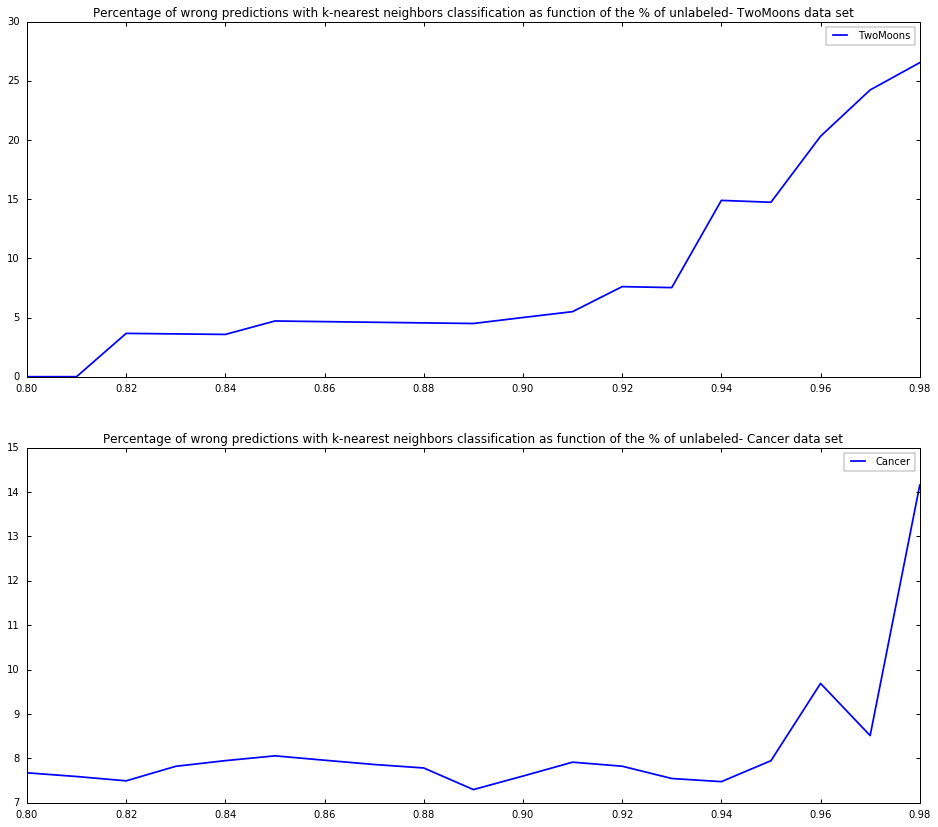

In [ ]:
#  Question 9  : Complete the function self_training
from sklearn.neighbors import KNeighborsClassifier

class twoMoonsClass:
    def __init__(self, noise = 0.05, n_samples = n_samples):
        twoMoons = make_moons(n_samples = n_samples, noise=0.05)
        self.data = twoMoons[0]
        self.target = twoMoons[1]


twomoons = twoMoonsClass(0.05, n_samples)# pas generer nouveau chaque fois
cancer = load_breast_cancer()
dataSets = [(twomoons,"TwoMoons"), (cancer,"Cancer")]
cpt = 0
pErrorArray = []
p_unlabelleds = np.arange(80,99)/100 # pecentages of unlabelled 
neigh = KNeighborsClassifier(n_neighbors=3)

for dataSet in dataSets:
    for p_unlabelled in p_unlabelleds:
        semi_sup_dat_dataSet = semi_sup_dat(dataSet[0], p_unlabelled, dataSet[1])
        neigh.fit(semi_sup_dat_dataSet.X_lab , semi_sup_dat_dataSet.y_lab)
        pred = neigh.predict(semi_sup_dat_dataSet.X_unlab)
        error = 0
        for i in range(len(semi_sup_dat_dataSet.y_unlab)):
            if semi_sup_dat_dataSet.y_unlab[i] != pred[i]:
                error += 1       
        error = error/len(semi_sup_dat_dataSet.y_unlab)*100
        pErrorArray.append(error)
        
    cpt += 1
    plt.subplot(len(dataSets), 1, cpt)  
    plt.plot(p_unlabelleds, pErrorArray, label = semi_sup_dat_dataSet.name)
    plt.title("Percentage of wrong predictions with k-nearest " + 
          "neighbors classification as function of the % of unlabeled"
          + "- " + semi_sup_dat_dataSet.name + " data set")
             
    plt.legend()
    pErrorArray = []

### Question 10 : Complete the code in the box below

###### Closed form expression :

The minimization problem is as follows:
$$\min_{f\in \mathcal{H}_\mathcal{K}} \frac{1}{l}\sum_{i = 1}^l (y_i - f(x_i))^2 + \lambda\Vert f \Vert_{\mathcal{H}_\mathcal{K}}^2 + \frac{\lambda_u}{(u+l)^2} f^\top L f$$

The representer theorem tells us that $f^\star$ can me written as:

$f^\star(.) = \sum_{i=1}^{l+u} \mathcal{K}(.,x_i)\alpha_i + b$ with $K_i$ being the $i^{th}$ line of the Gram matrix.

However, b being a more offset, it doesn't change the value of $\alpha^\star$ that minimizes the convex loss. <br /> Therefore, we plug $f^\star(.) = \sum_{i=1}^{l+u} \mathcal{K}(.,x_i)\alpha_i$ into our minimization problem to find $\alpha^\star$.

We first rewrite some terms:

$\begin{align}
\sum_{i=1}^l (y_i - f(x_i))^2 &= \sum_{i=1}^l \left(y_i\right)^2 - \sum_{i=1}^l \left(y_i . K_i . \alpha \right)^2 
    + \sum_{i=1}^l (K_i . \alpha)^2 \\
    &= y^\top.y - 2.y^\top.K.\alpha + (J.K.\alpha)^\top.(J.K.\alpha)  \\
    &= y^\top.y - 2.y^\top.K.\alpha + \alpha^\top.K.J.K.\alpha
\end{align}$

From paper[2] we know that: <br />
$\Vert f \Vert_{\mathcal{K}}^2 = \alpha^\top.K.\alpha$

Since $f(x_i) = K_i.\alpha$ with $K_i$ being the the $i^{th}$ line of the Gram matrix: <br />
$f = K.\alpha \\$ , implies 
$f^\top = \alpha^\top.K^\top$

$K^\top = K$ since $K$ is symmetric, so $f^\top = \alpha^\top.K$ <br />
And $f^\top.L.f = \alpha^\top.K.L.K.\alpha$

We can then rewrite the minimization problem as:

$
\alpha^\star = argmin_\alpha [\frac{1}{l} (y^\top.y - 2.y^\top.K.\alpha + \alpha^\top.K.J.K.\alpha) + \lambda.\alpha^\top.
K.\alpha + \frac{\lambda_u}{(u+l)^2}.\alpha^\top.K.L.K.\alpha]
$

We know that: $\nabla[x^\top.A.x] = (A + A^\top).x$ <br />

$K.J.K$, $K$, and $K.L.K$ are symmetric, so we have:


$\begin{align}
\nabla[loss] \\
&= -\frac{2}{l}.K.y + \frac{2}{l}.K.J.K.\alpha + 2.\lambda.K.\alpha + \frac{\lambda_u}{(u+l)^2}.2.K.L.K \\
&= \frac{2}{l}.[K.J + \lambda.l.I_n + \frac{\lambda_u}{(u+l)^2}.K.L.K].K.\alpha - \frac{2}{l}.K.y
\end{align}$

Since convexe and differentiable loss, gradient of the loss = 0 at $\alpha^\star$

And finally we have: $ \alpha^\star = \left(\lambda l I_n + JK + \frac{\lambda_u l}{(u+l)^2} LK \right)^{-1} y$

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel # Or reimplement it yourself if your prefer
from scipy.linalg import block_diag

### Question 11 : Complete the code in the box below

In [ ]:

def similarity(A, B):
    return np.sum(np.multiply(A,B))/(LA.norm(A)*LA.norm(B))



def lapRLSpredict(dataSet, labda, labdaU):
    
    l = len(dataSet.y_lab)
    u = len(dataSet.y_unlab)
    n = len(dataSet.y_lab) + len(dataSet.y_unlab)
    J = np.zeros((n,n))
    idx = np.arange(l+1)
    J[idx,idx] = 1

    X = np.concatenate([dataSet.X_lab, dataSet.X_unlab])
    adjencyMatrix = rbf_kernel(X, X) 
    kernelMatrix = rbf_kernel(X, X)
    D = np.zeros((n,n))

    degree = 0
    for i in range(n):
        for j in range(n):
            degree += adjencyMatrix[i][j]        
        D[i][i] = degree
        degree = 0

    L = D - kernelMatrix
    Y = np.concatenate([dataSet.y_lab, np.zeros(u)])
    alpha = np.linalg.inv(J.dot(kernelMatrix) + labda*l*np.identity(n) + l*labdaU/(n*n)*L.dot(kernelMatrix)).dot(Y)
    pred = alpha.T.dot(rbf_kernel(X, dataSet.X_unlab))
    return pred

lbda = 1e-6
lbdaUs = (np.arange(10)+1)*100000
similarityArray = []

for lbdaU in lbdaUs:
    y_pred = lapRLSpredict(Mnist, lbda, lbdaU)
    similarityRate = similarity(y_pred, Mnist.y_unlab)
    similarityArray.append(similarityRate)

plt.xscale('log')
plt.plot(lbdaUs, similarityArray, label = "similarity")
plt.title("Cosine similarity between the vector of y_unlabels and the corresponding vector of predictions")         
plt.legend()


We observe that the predictions that we got with the lapRLS gets better as lambda_u grows untul lambda_u reaches about 4.10^5. There the accuracy of the actual prediction on the untrained dataset seems to reach a maximum. 

### Question 12 : Add your answer here

- The problem related to the close form implementation is that we have to compute the inverse of a (l+u) x (l+u) matrix. 
- In some cases the inverse of the matrix might not even be computable
- Itt leads some computations' costs issues anyway whenever (l+u) = n the size of the data set become too great.

### Question 13 : Complete the code in the box below

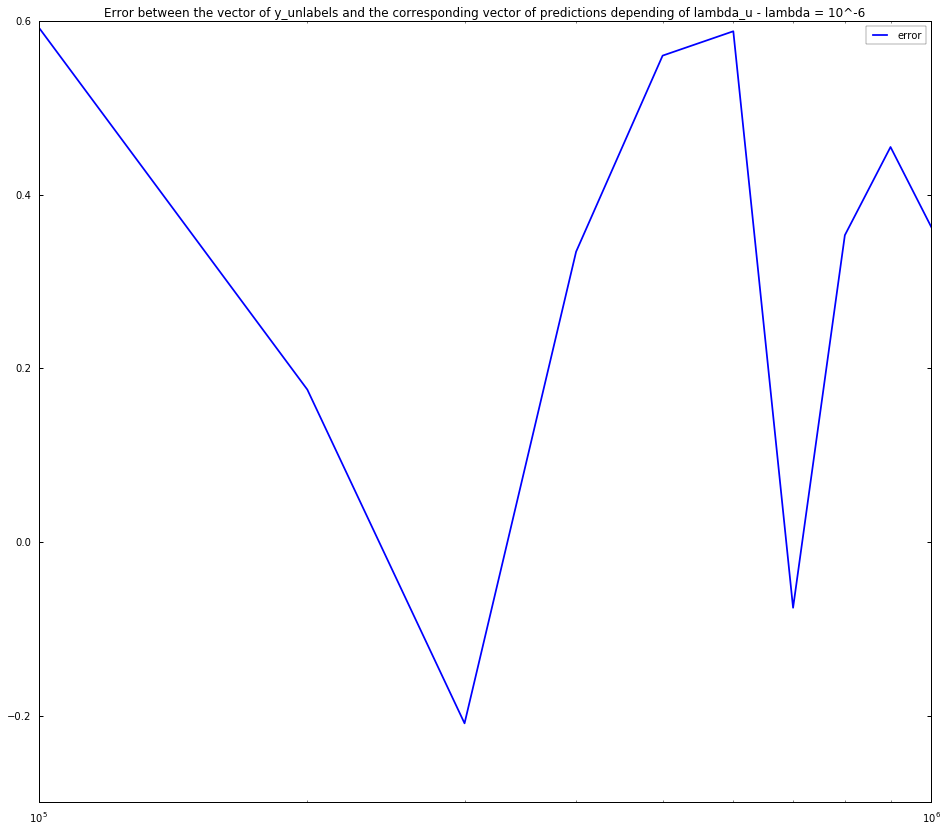

In [ ]:
def grad_i(A, K, l, i, alpha, Y):
    return A[i].dot(alpha) - K[i].dot(Y)

def sgd(A, K, l, Y,x_init, iis, grad_i, n_iter=100, step=1.):
    x = x_init.copy()   
    
    for indx in range(n_iter):
        i = iis[indx]        
        x = x - step / np.sqrt(indx+1) * grad_i(A, K, l, i, x, Y)
    return x

def similarity(A, B):
    return np.sum(np.multiply(A,B))/(LA.norm(A)*LA.norm(B))

def lapRLSpredictWithSgd(dataSet, labda, labdaU):
       
    l = len(dataSet.y_lab)
    u = len(dataSet.y_unlab)
    n = len(dataSet.y_lab) + len(dataSet.y_unlab)
    n_iter = 100
    iis = np.random.randint(0, n, n * n_iter)
    
    J = np.zeros((n,n))
    idx = np.arange(l+1)
    J[idx,idx] = 1
    alpha = np.zeros(n)
    
    X = np.concatenate([dataSet.X_lab, dataSet.X_unlab])
    adjencyMatrix = rbf_kernel(X, X) 
    kernelMatrix = rbf_kernel(X, X)
    D = np.zeros((n,n))
    
    degree = 0
    for i in range(n):
        for j in range(n):
            degree += adjencyMatrix[i][j]        
        D[i][i] = degree
        degree = 0
      
    L = D - adjencyMatrix
    Y = np.concatenate([dataSet.y_lab, np.zeros(u)])
    
    A = 2/l*(kernelMatrix.dot(J.dot(kernelMatrix) + l * lbda * np.eye(n) + (labdaU * l)/(n*n) * kernelMatrix.dot(L)))
    step=1.
    alpha = sgd(A, kernelMatrix, l, Y, alpha, iis, grad_i, n_iter=100, step=1.)  
    
    pred = alpha.T.dot(rbf_kernel(X, dataSet.X_unlab))
    return pred


lbda = 1e-6
lbdaUs = (np.arange(10)+1)*100000
errorArray = []

for lbdaU in lbdaUs:    
    similarite = np.sum(np.multiply(lapRLSpredictWithSgd(Mnist, lbda, lbdaU),Mnist.y_unlab))/(LA.norm(lapRLSpredictWithSgd(Mnist, lbda, lbdaU))*LA.norm(Mnist.y_unlab))
    error = 1 - similarite
    errorArray.append(error)

plt.xscale('log')
plt.plot(lbdaUs, errorArray, label = "error")
plt.title("Error between the vector of y_unlabels and the corresponding vector of predictions depending of lambda_u - lambda = 10^-6")         
plt.legend()

### Question 14 : Complete the code in the box below

##### Add your answer to the question here :

-

-

-

### Question 15 : Complete the code in the box below

### Question 16 : Complete the code in the box below

###### Describe your protocol here : 
-

-

-